# Problem Set 05: MDPs and HMMs

In this problem set you will implement value iteration in a non-deterministic MDP, and HMM Filtering.


0. [Credit for Contributors (required)](#contributors)

1. [Non-deterministic MDPs](#problem1)
    1. [Value Iteration (25 points)](#v_iteration)
    2. [Extract the Policy from V* (15 points)](#v_to_policy)
    3. [Policy Observations (20 points)](#policy_observations)
      
2. [HMM Filtering](#problem2)
    1. [Implement `compute_casino_table` for fair dice estimation (40 points)](#compute_casino_table)
    2. [Dendrochronology Example (20 points)](#viterbi)
    
**120 points** total for Problem Set 5



## <a name="contributors"></a> Credit for Contributors

List the various students, lecture notes, or online resouces that helped you complete this problem set:

Ex: I worked with Bob on the cat activity planning problem.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

I worked with Tom Stuart, Anup Sreekumar, Skylar Eiskowitz and the twins on this assignment for my coding. I worked with Nils to bounce some ideas off of him for the Viterbi decoding at the bottom.

In [282]:
# Useful imports

from __future__ import division

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
from nose.tools import ok_, assert_equal, assert_almost_equal
from grid import MDPGrid, generate_mdp_plot
from mdp_utils import MDP, build_mdp

## <a name="problem1"></a> Problem 1: Non-deterministic MDPs (60 points)

In this problem you will implement value iteration in a non-deterministic MDP grid world in order to compute the optimal policy. You will then plot the results and discuss your observations for different parameters of the MDP model.

We are giving you a simple MDP class that you can use for this problem. This class is defined in the `mdp_utils.py` file. You should open this file now to look at the class definition: especially at the properties of MDP (S, A, T, R, gamma).

The non-deterministic MDP model that we'll use in this problem is the same one described in chapter 17.1 of the AIMA book.

Basically, the robot is in a grid world and can perform four actions at any time: `up`, `down`, `right` and `left`. However, because it's not a deterministic world, the outcome of these actions is not perfect. After executing an action, the robot will move in its intended direction with probability `p`. However, with probability `1-p` it will move at right angles to the intended direction. However, note that if the outcome of the action makes the robot bump into the walls of the world, the robot will bounce back and stay in the same state. For example, from the state `(1,1)`, the action `up` moves the agent to `(1,2)` with probability 0.8, but with probability 0.1, it moves right to `(2,1)`, and with probability 0.1, it moves left, bumps into the wall, and stays in `(1,1)`.

The world is an `n x n` grid. There is a terminal goal cell. The robot receives reward `goal_reward` when arriving to the goal cell from any other neighbor cell. Similarly, there are obstacle cells. The robot receives (negative) reward `obstacle_reward` when arriving to these cells. Both the goal and the obstacle cells are terminal: the robot can't leave these cells once it lands on them.

The goal is to find the optimal policy for the robot.

Luckily (for you), we are providing the function build_mdp that generates the MDP for this grid world.

```
def build_mdp(n, p, obstacles, goal, gamma, goal_reward=100, obstacle_reward=-1000)
```





The following example generates an MDP for the following `3x3` grid with goal state `(2,2)` (green circle) and obstacle in `(0,1)` (black circle).

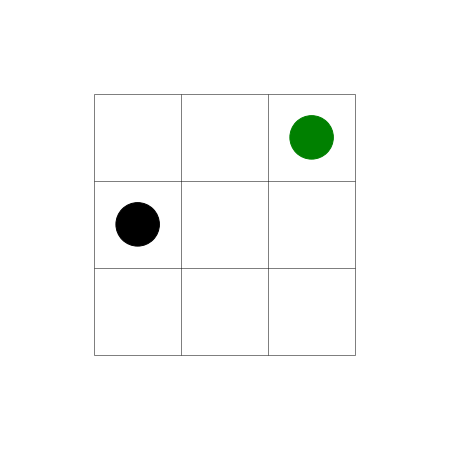

In [272]:
n = 3
goal = (2,2)
obstacles = [(0,1)]

# Build MDP
mdp = build_mdp(n,0.8, obstacles, goal,0.8)

# Create grid for plotting
g = MDPGrid(n,n)
axes = g.draw()
# Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')
    

The print command prints the information about the MDP that we just generated (MDP models get large pretty fast).

In [273]:
# Print info about MDP model that we just generated.
mdp.print_mdp()

MDP: 
  States (9): '(0, 1)', '(1, 2)', '(2, 1)', '(0, 0)', '(1, 1)', '(2, 0)', '(0, 2)', '(2, 2)', '(1, 0)'
  Actions (4): ['up', 'down', 'right', 'left']
  Transitions:
   + State '(0, 0)'
     -action 'up'
       to '(0, 1)' with p=0.80
       to '(1, 0)' with p=0.10
       to '(0, 0)' with p=0.10
     -action 'down'
       to '(0, 0)' with p=0.90
       to '(1, 0)' with p=0.10
     -action 'right'
       to '(1, 0)' with p=0.80
       to '(0, 1)' with p=0.10
       to '(0, 0)' with p=0.10
     -action 'left'
       to '(0, 0)' with p=0.90
       to '(0, 1)' with p=0.10
   + State '(0, 1)'
     -action 'up'
       to '(0, 1)' with p=1.00
     -action 'down'
       to '(0, 1)' with p=1.00
     -action 'right'
       to '(0, 1)' with p=1.00
     -action 'left'
       to '(0, 1)' with p=1.00
   + State '(0, 2)'
     -action 'up'
       to '(0, 2)' with p=0.90
       to '(1, 2)' with p=0.10
     -action 'down'
       to '(0, 1)' with p=0.80
       to '(1, 2)' with p=0.10
       to '(0, 

### <a name="v_iteration"></a> Implement Value Iteration (25 points)

In this part of the problem you will implement **value iteration** for a given MDP.

Your function should have the following signature:

```python
def value_iteration(mdp, epsilon=1e-3)
```

The function should take an MDP instance (like the generated by the `build_mdp` function) and a value for `epsilon` that you'll use to determine when to stop value iteration (as explained in the lecture notes).

The function should return a Python dictionary with the optimal value for each state in the MDP. Your function should also print how many iterations it took to reach convergence for the given epsilon value.

As an example of what your function should return, have a look at what a random Value function would look like.

In [274]:
def random_V(mdp):    
    states = mdp.S
    V_random = dict()
    minV, maxV = -100, 100
    random_values = np.random.uniform(minV,maxV,[len(states),1])
    for i, s in enumerate(states):
        V_random[s] = random_values[i]
    return V_random
print("V_random is a valid Value function, although definitely not optimal (it's just random!)")
mdp = build_mdp(n,0.8, [], (1,1),0.8)
V_random = random_V(mdp)
V_random

V_random is a valid Value function, although definitely not optimal (it's just random!)


{(0, 1): array([83.39238156]),
 (1, 2): array([17.1511679]),
 (2, 1): array([-53.42762183]),
 (0, 0): array([28.00977265]),
 (1, 1): array([-76.53474008]),
 (2, 0): array([-70.74565424]),
 (0, 2): array([-77.03377973]),
 (2, 2): array([49.31464]),
 (1, 0): array([-13.75606428])}

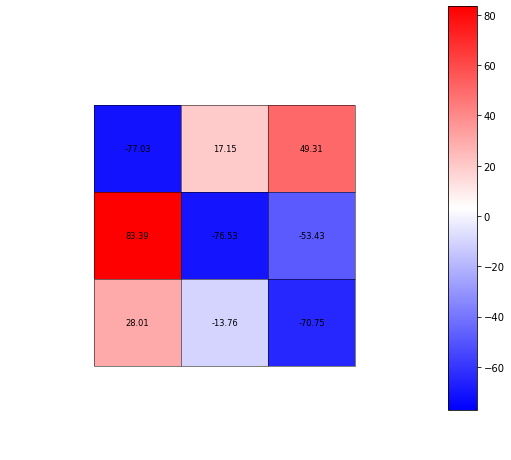

In [275]:
# The previous random V can be plotted in the grid.
n = 3
# Create grid for plotting
g = MDPGrid(n,n)
axes = g.draw()
# Plot V in the grid
g.plot_V(axes, V_random, print_numbers=True)

<div class="alert alert-info">
Implement function `value_iteration(mdp, epsilon=1e-3)` below.
</div>

<div class="alert alert-warning">
**Note**: Assume that if some some combination of `s`, `a` and `s_dest` is not found in the `reward` of the MDP (that is, you get an error when trying to access `mdp.R[s][a][s_dest]`, then the reward should be 0.
</div>

In [276]:
# Write your code for value iteration in this cell

# YOUR CODE HERE
def value_iteration(mdp, epsilon=1e-3):
    U1 = {s: 0 for s in mdp.S} 
    
    R, T, gamma = mdp.R, mdp.T, mdp.gamma #mdp.R is the reward function, T is the transition probability, gamma is the discount factor
    
    
    while True:
        answer = U1.copy()
        
        U1_potential = U1.copy() #create a candidate list

        delta = 0

        for s in mdp.S: #for each state in the set of states
            
            for a in mdp.A: #mdp.A is the set of actions... for each action in the set of actions
                
                U1_potential[s]=0
                
                transition_dict = T[s][a] #create a transition from s using transition a
                
                transitions = list(transition_dict.items())
                #find hte optimal next action, then use this in to update the expected optimal future output
                for transition in transitions:
                    (s1, p) = (transition[0], transition[1])
                    if s1 not in R[s][a]:
                        R[s][a][s1] = 0
                    U1_potential[s]+= p*R[s][a][s1]+ gamma * (p * answer[s1])
                if U1_potential[s]>U1[s]:
                    U1[s]=U1_potential[s]

            delta = max(delta, abs(U1[s] - answer[s]))
        if delta <= epsilon * (1 - gamma) / gamma:
            return answer







V:



{(0, 1): 0,
 (1, 2): 93.16960221799948,
 (2, 1): 93.16960221799948,
 (0, 0): 15.600366088152697,
 (1, 1): 71.45042550699876,
 (2, 0): 69.56180144517232,
 (0, 2): 26.619298853079002,
 (2, 2): 0,
 (1, 0): 54.60389887550691}

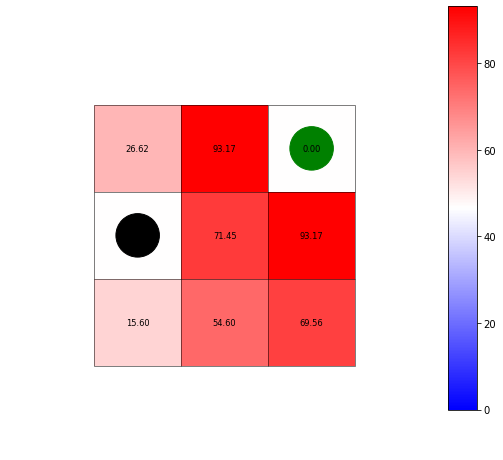

In [277]:
# Test your code for value iteration with the example from before
# Don't modify this cell (it may be overwritten)
n = 3
goal = (2,2)
obstacles = [(0,1)]

# Build MDP
mdp = build_mdp(n,0.8, obstacles, goal,0.8)

# Create grid for plotting
g = MDPGrid(n,n)
axes = g.draw()
# Perform value iteration
V = value_iteration(mdp, epsilon=1e-3)
g.plot_V(axes, V, print_numbers=True)
# Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')
print("V:\n")
V


### <a name="v_to_policy"></a> Extract the policy from V* (15 points)

Create function `extract_policy(mdp, V)` that extracts the optimal policy from V. The output of this function should be a Python dictionary mapping each state to the best action to take (e.g. `up`,`down`,`right`,`left`)

The following shows a simple random policy that will give you an idea of the format that the `extract_policy` function should produce.

In [278]:
def random_policy(mdp):
    states = mdp.S
    actions = mdp.A
    Pi_random = dict()
    random_values = np.random.randint(0, len(actions),[len(states),1])
    
    for i, s in enumerate(states):
        Pi_random[s] = actions[int(random_values[i])]
        
    return Pi_random

# The previous random V can be plotted in the grid.
n = 3
mdp = build_mdp(n,0.8, [], (1,1),0.8)
g = MDPGrid(n,n)
axes = g.draw()

Pi_random = random_policy(mdp)
g.plot_policy(axes, Pi_random)

<div class="alert alert-info">
Implement function `extract_policy(mdp, V)` below.
</div>

In [279]:
# Write your code for the policy extraction in this cell

def extract_policy(mdp, V):
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    pi,pi_candidate = {s: 'up' for s in mdp.S},{s: 'up' for s in mdp.S}
    pi_val,pi_val_candidate,pi_val_check= {s: 0 for s in mdp.S},{s: 0 for s in mdp.S},{s: 0 for s in mdp.S}
    for s in mdp.S:
        for a in mdp.A: 
            pi_val_candidate[s]=0
            transition_dict = T[s][a]
            transitions = list(transition_dict.items())
            for transition in transitions:
                (s1, p) = (transition[0], transition[1])
                if s1 not in R[s][a]: 
                    R[s][a][s1] = 0
                pi_val_candidate[s]+= (p * (R[s][a][s1]+V[s1])) 
            
            if pi_val_candidate[s]>pi_val[s]:
                pi_val[s]=pi_val_candidate[s]
                pi_candidate[s]=a

        transition_dict = T[s][pi[s]]
        transitions = list(transition_dict.items())
        
        for transition in transitions:
            (s1, p) = (transition[0], transition[1])
            pi_val_check[s] += (p *  (R[s][pi[s]][s1]+V[s1]))
        if pi_val[s]>pi_val_check[s]:
            pi[s]=pi_candidate[s]

    return pi




Now we'll test both your optimal policy in the example we have been using. Execute but, don't modify, the following cell.

In [280]:
# Test your code for value iteration with the example from before
# Don't modify this cell (it may be overwritten)
n = 3
goal = (2,2)
obstacles = [(0,1)]

# Build MDP
mdp = build_mdp(n,0.8, obstacles, goal,0.8)

# Create grid for plotting
g = MDPGrid(n,n)
axes = g.draw()
# Perform value iteration
V = value_iteration(mdp, epsilon=1e-3)
# Extract the policy
Pi = extract_policy(mdp, V)

g.plot_V(axes, V, print_numbers=False)
g.plot_policy(axes, Pi)

# Draw goal and obstacle cells
g.draw_cell_circle(axes, goal, color='g')
for ob in obstacles:
    g.draw_cell_circle(axes, ob, color='k')

### <a name="policy_observations"></a> Observations (20 points)

We'll now run your code on a larger grid with more obstacles.
Execute the following code:


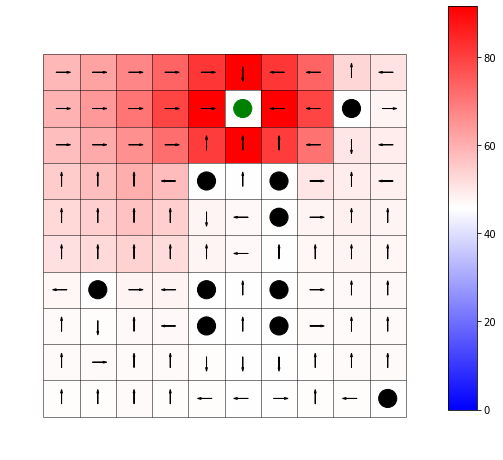

In [281]:
# Don't modify this code
n = 10
goal = (5,8)
# goal = (4,2)
obstacles = [(1,3), (9,0), (8,8)] + \
            [(4, 2), (4, 3), (4, 6)] + \
            [(6, 2), (6, 3), (6, 5), (6, 6)]
mdp = build_mdp(n,p=0.8, obstacles=obstacles,goal=goal,gamma=0.8, goal_reward=100, obstacle_reward=-500)
V = value_iteration(mdp)
Pi = extract_policy(mdp, V)
generate_mdp_plot(mdp, V, Pi, obstacles, goal)

What can you see? Does this policy look optimal? Does it look like the robot is doing something strange? Why? (hint: remember the transition model that we are using in this example)

<div class="alert alert-info">
**Discuss your results in the cell below**
</div>


The robot isn't choosing ths shortest path. In essence, the robot is avoiding penalties, which is a product of how we have defined the game. In theory we could adjust the reward functions to get a shortest path... however the path right now makes sense for the model we have given it.

Try running the previous example with a couple variations of the values for `p`, `gamma` and the reward values.

How do this values affect the policy that we get?
(a brief qualitative answer is sufficient, no need for numerical analysis)


<div class="alert alert-info">
**Please discuss below**
</div>


Changing these values distinctly changes the optimal policy. When we change the discount factor to a very low number (future rewards are worth way less), our behavior becomes almost risk seeking. When we change the reward values for obstacles to lower values in negative magnitude, our policy will skirt closer to them en route to the goal. The opposite is true when the reward values are increased in negative magnitude. Our policy then avoids them "like the plague". As for p, when the probability changes, the closer it gets to a lower number the more random our policy becomes.

## <a name="problem2"/></a> Problem 2 : HMM  Filtering (60 points)

In this problem you will perform filtering on an HMM using the forward algorithm (as explained in class).

Remember that the filtering problem answers the question

\begin{equation}
Pr(S_t | o_{1:t})
\end{equation}

that is, what is the most likely state at time $t$ after reading $t$ observations.

You will implement filtering and demonstrate it for the "dishonest casino" example HMM that Pedro introduced in class. The parameters for the HMM are shown in the following image (and also in the lecture notes).

<img src='hmm_casino.png'/>

Also, the prior for the states is

\begin{align}
    &Pr(S_0 = Fair) &= 0.8\\
    &Pr(S_0 = Loaded) &= 0.2
\end{align}

that is, the probability that the initial state is "Fair" is 0.8, and the probability that the initial state is "Loaded" is 0.2.

Implement filtering for this HMM for the following observation sequence:

`['1','2','4','6','6','6','3','6']`

Your code should produce a table like the following one (from 0 measurements to the totality of the measurements provided).


```
Filtering for the dishonest casino HMM:
  with 0 measurement(s): [], P(s at t=0) is: [Fair: 0.8000,  Loaded: 0.2000]
  with 1 measurement(s): ['1'], P(s at t=1) is: [Fair: 0.8480,  Loaded: 0.1520]
  with 2 measurement(s): ['1', '2'], P(s at t=2) is: [Fair: 0.8789,  Loaded: 0.1211]
  with 3 measurement(s): ['1', '2', '4'], P(s at t=3) is: [Fair: 0.8981,  Loaded: 0.1019]
  with 4 measurement(s): ['1', '2', '4', '6'], P(s at t=4) is: [Fair: 0.6688,  Loaded: 0.3312]
  ...
```

Note that this is exactly the example given in class and that you have the results in the slides.

<div class="alert alert-info">
Implement HMM filtering and use it in the "dishonest casino" example HMM to generate a table like the one above.
</div>


**Note**: you could implement `smoothing` and `decoding` on the same HMM model and observation data for **additional credit** (but you don't have to if you don't want). 

If you do implement smoothing and decoding, please make it explicit in a separate cell below for our graders to see.

In [67]:
# You might find the following examples on how to use numpy for matrices and vectors useful

# Define a 2x3 Matrix
M=np.array([[3.5, 2.1, 1.3],
            [0.1,0.2,0.3]])
print("Matrix M is:")
print(M)

print("Element (0,1) of M is: ", M[0,1])
print("Shape (dimension) of M is: ", M.shape)

# Define 1x2 vector
v =  np.array([1, 3])
print("Vector v is:")
print(v)

# Matrix multiplication r = v*M
r = v.dot(M)
print("Matrix multiplication v * M = ", r)

# Element wise multiplication
a = np.array([2, 4])
print("Element wise v * a = %s * %s = "%(v,a), v*a)

# Sum of elements of v
print("Sum of elements of v (%s) is: %s" %(v, np.sum(v)))

# Vector slicing
b = np.array([2,4,6,8,10,12,14,16])
print("Vector b is: ", b)
print("First 3 elements of b are: ", b[:3])
print("Elements from the second until the end are: ", b[1:])
print("Elements from 4th to 7th are: ", b[3:7])


Matrix M is:
[[3.5 2.1 1.3]
 [0.1 0.2 0.3]]
Element (0,1) of M is:  2.1
Shape (dimension) of M is:  (2, 3)
Vector v is:
[1 3]
Matrix multiplication v * M =  [3.8 2.7 2.2]
Element wise v * a = [1 3] * [2 4] =  [ 2 12]
Sum of elements of v ([1 3]) is: 4
Vector b is:  [ 2  4  6  8 10 12 14 16]
First 3 elements of b are:  [2 4 6]
Elements from the second until the end are:  [ 4  6  8 10 12 14 16]
Elements from 4th to 7th are:  [ 8 10 12 14]


 ###  <a name="compute_casino_table"></a>Implement HMM Filter

Write your code as a function:

```
def compute_casino_table(meas)
```

that takes as input the observation sequence, and prints the table discussed above.


In [254]:
import pdb #debugger tool import
def compute_casino_table(meas):
    # Example observation sequence
    # meas = ['1','2','4','6','6','6','3','6']
    p_fair=np.ones(len(meas)+1)
    p_loaded=np.ones(len(meas)+1)
    p_loaded[0]=.2
    p_fair[0]=.8
    trans=np.array([[.95,.05],[.05,.95]])
    print("Filtering for the dishonest casino HMM:")
    print("with 0 measurement(s): [], P(s at t=0) is: [Fair:", p_fair[0],",  Loaded: ",p_loaded[0],"]")
    if len(meas)>1:
        for q in range(1, len(meas)+1):
            p_fai=1/6
            if meas[q-1]=='6':
                p_load=.5
            else:
                p_load=.1
            #pdb.set_trace()
            normy=p_load*(.95*p_loaded[q-1]+.05*p_fair[q-1])+p_fai*(.95*p_fair[q-1]+.05*p_loaded[q-1])
            p_loaded[q]=round(p_load*(.95*p_loaded[q-1]+.05*p_fair[q-1])/(normy),4)
            p_fair[q]=round(p_fai*(.95*p_fair[q-1]+.05*p_loaded[q-1])/normy,4)
            print("with",q," measurement(s):", meas[:q], " , P(s at t=",q,") is: [Fair:",p_fair[q],", Loaded: ",p_loaded[q],"]")
        return 



In [249]:
def smooth_casino_tables(meas):
    p_fair=np.ones(len(meas)+1)
    p_loaded=np.ones(len(meas)+1)
    p_loaded[0]=.2
    p_fair[0]=.8
    print("Smoothing for the dishonest casino HMM:\n")
    #print("with 0 measurement : [], P(s at t=0) is: [Fair:", p_fair[0],",  Loaded: ",p_loaded[0],"]")
    for q in range(1, len(meas)+1):
        p_fair_o=1/6
        if meas[q-1]=='6':
            p_loaded_0=.5
        else:
            p_loaded_0=.1
        eta=p_loaded_0*(.95*p_loaded[q-1]+.05*p_fair[q-1])+p_fair_o*(.95*p_fair[q-1]+.05*p_loaded[q-1])
        p_loaded[q]=round(p_loaded_0*(.95*p_loaded[q-1]+.05*p_fair[q-1])/(eta),4)
        p_fair[q]=round(p_fair_o*(.95*p_fair[q-1]+.05*p_loaded[q-1])/eta,4)
        
    b_fair=np.ones(len(meas)+1)
    b_loaded=np.ones(len(meas)+1)
    p_tilde_fair=np.ones(len(meas)+1)
    p_tilde_loaded=np.ones(len(meas)+1)
    b_loaded[-1]=1
    b_fair[-1]=1
    for m in reversed(range(1, len(meas)+1)):
        p_fair_o=1/6
        if meas[m-1]=='6':
            p_loaded_o=.5
        else:
            p_loaded_o=.1

        b_loaded[m-1]=(p_loaded_o*.95*b_loaded[m]+p_fair_o*.05*b_fair[m])
        b_fair[m-1]=(p_fair_o*.95*b_fair[m]+p_loaded_o*.05*b_loaded[m])

    for k in (range(0, len(meas)+1 )):
        eta = p_loaded[k] * b_loaded[k] + p_fair[k] * b_fair[k]
        p_tilde_fair[k] = b_fair[k] * p_fair[k]/eta
        p_tilde_loaded[k] = b_loaded[k] * p_loaded[k]/eta
        print("with", k, " measurement(s):", meas[:k], " , P(s at t=", k, ") is: [Fair:", round(p_tilde_fair[k],4), ", Loaded: ",
              round(p_tilde_loaded[k],4), "]")
    return
meas = ['1','2','4','6','6','6','3','6']
smooth_casino_tables(meas)

Smoothing for the dishonest casino HMM:

with 0  measurement(s): []  , P(s at t= 0 ) is: [Fair: 0.7382 , Loaded:  0.2618 ]
with 1  measurement(s): ['1']  , P(s at t= 1 ) is: [Fair: 0.694 , Loaded:  0.306 ]
with 2  measurement(s): ['1', '2']  , P(s at t= 2 ) is: [Fair: 0.6116 , Loaded:  0.3884 ]
with 3  measurement(s): ['1', '2', '4']  , P(s at t= 3 ) is: [Fair: 0.4678 , Loaded:  0.5322 ]
with 4  measurement(s): ['1', '2', '4', '6']  , P(s at t= 4 ) is: [Fair: 0.223 , Loaded:  0.777 ]
with 5  measurement(s): ['1', '2', '4', '6', '6']  , P(s at t= 5 ) is: [Fair: 0.1445 , Loaded:  0.8555 ]
with 6  measurement(s): ['1', '2', '4', '6', '6', '6']  , P(s at t= 6 ) is: [Fair: 0.1265 , Loaded:  0.8735 ]
with 7  measurement(s): ['1', '2', '4', '6', '6', '6', '3']  , P(s at t= 7 ) is: [Fair: 0.1449 , Loaded:  0.8551 ]
with 8  measurement(s): ['1', '2', '4', '6', '6', '6', '3', '6']  , P(s at t= 8 ) is: [Fair: 0.1399 , Loaded:  0.8601 ]


In [255]:
# Don't modify this cell
meas = ['1','2','4','6','6','6','3','6']
compute_casino_table(meas)

Filtering for the dishonest casino HMM:
with 0 measurement(s): [], P(s at t=0) is: [Fair: 0.8 ,  Loaded:  0.2 ]
with 1  measurement(s): ['1']  , P(s at t= 1 ) is: [Fair: 0.848 , Loaded:  0.152 ]
with 2  measurement(s): ['1', '2']  , P(s at t= 2 ) is: [Fair: 0.8789 , Loaded:  0.1211 ]
with 3  measurement(s): ['1', '2', '4']  , P(s at t= 3 ) is: [Fair: 0.8981 , Loaded:  0.1019 ]
with 4  measurement(s): ['1', '2', '4', '6']  , P(s at t= 4 ) is: [Fair: 0.6688 , Loaded:  0.3312 ]
with 5  measurement(s): ['1', '2', '4', '6', '6']  , P(s at t= 5 ) is: [Fair: 0.3844 , Loaded:  0.6156 ]
with 6  measurement(s): ['1', '2', '4', '6', '6', '6']  , P(s at t= 6 ) is: [Fair: 0.1793 , Loaded:  0.8207 ]
with 7  measurement(s): ['1', '2', '4', '6', '6', '6', '3']  , P(s at t= 7 ) is: [Fair: 0.3088 , Loaded:  0.6912 ]
with 8  measurement(s): ['1', '2', '4', '6', '6', '6', '3', '6']  , P(s at t= 8 ) is: [Fair: 0.1399 , Loaded:  0.8601 ]


 ###  <a name="viterbi"></a>Dendrochronology Example
 
Dendrochronology (or tree-ring dating) is the scientific method of dating tree rings (also called growth rings) to the exact year they were formed in order to analyze atmospheric conditions during different periods in history. [Wikipedia]

<img src="tree-rings-diagram.jpg" style="width:40%;"/>
<p style="text-align:center">Image source: NASA </p>

Let’s say we are interested in estimating the average annual temperature at a particular location
on Earth. However, the time period that we are interested in is in distant past, with no direct
temperature data available. Prior research indicates correlation between size of tree rings and tem-
perature, so we decide to use this to as our evidence.

To simplify the problem, we’ll only consider two temperature states, “Hot” and “Cold”. Suppose
that we are told the probability of hot year followed by another hot year is 0.7 and the probability
that a cold year is followed by another cold year is 0.6. Assume that the initial state distribution, π, is given. For observations, we’ll only consider three different tree ring sizes, small, medium, and large, or S, M , and L, respectively. The probabilistic relationship between the annual temperature and the ring sizes is the observation matrix. The state transition matrix, initial distribution, and observation matrix are provided below:

<img src="temp_example.png"/>

For example, the probability of observing a “Large” tree ring size given that the state is “Hot” is 0.5.


From a particular four-year period of interest, we observe the series of tree rings, **[S, M, S, L]**. 

With this observation sequence, find the most likely temperature sequence using the **Viterbi
algorithm**. 

Please show how you found the most likely sequence.


<div class="alert alert-info">
Write or upload your answer in the cell below this one.
</div>

See Jpg below... sorry I write like a child, but you get the idea...
A carrot over the top of a component of the max argument in each viterbi sequence annotates that that probability helped determine the states, whether it was the probability of Cold to Cold or Cold to Hot etc

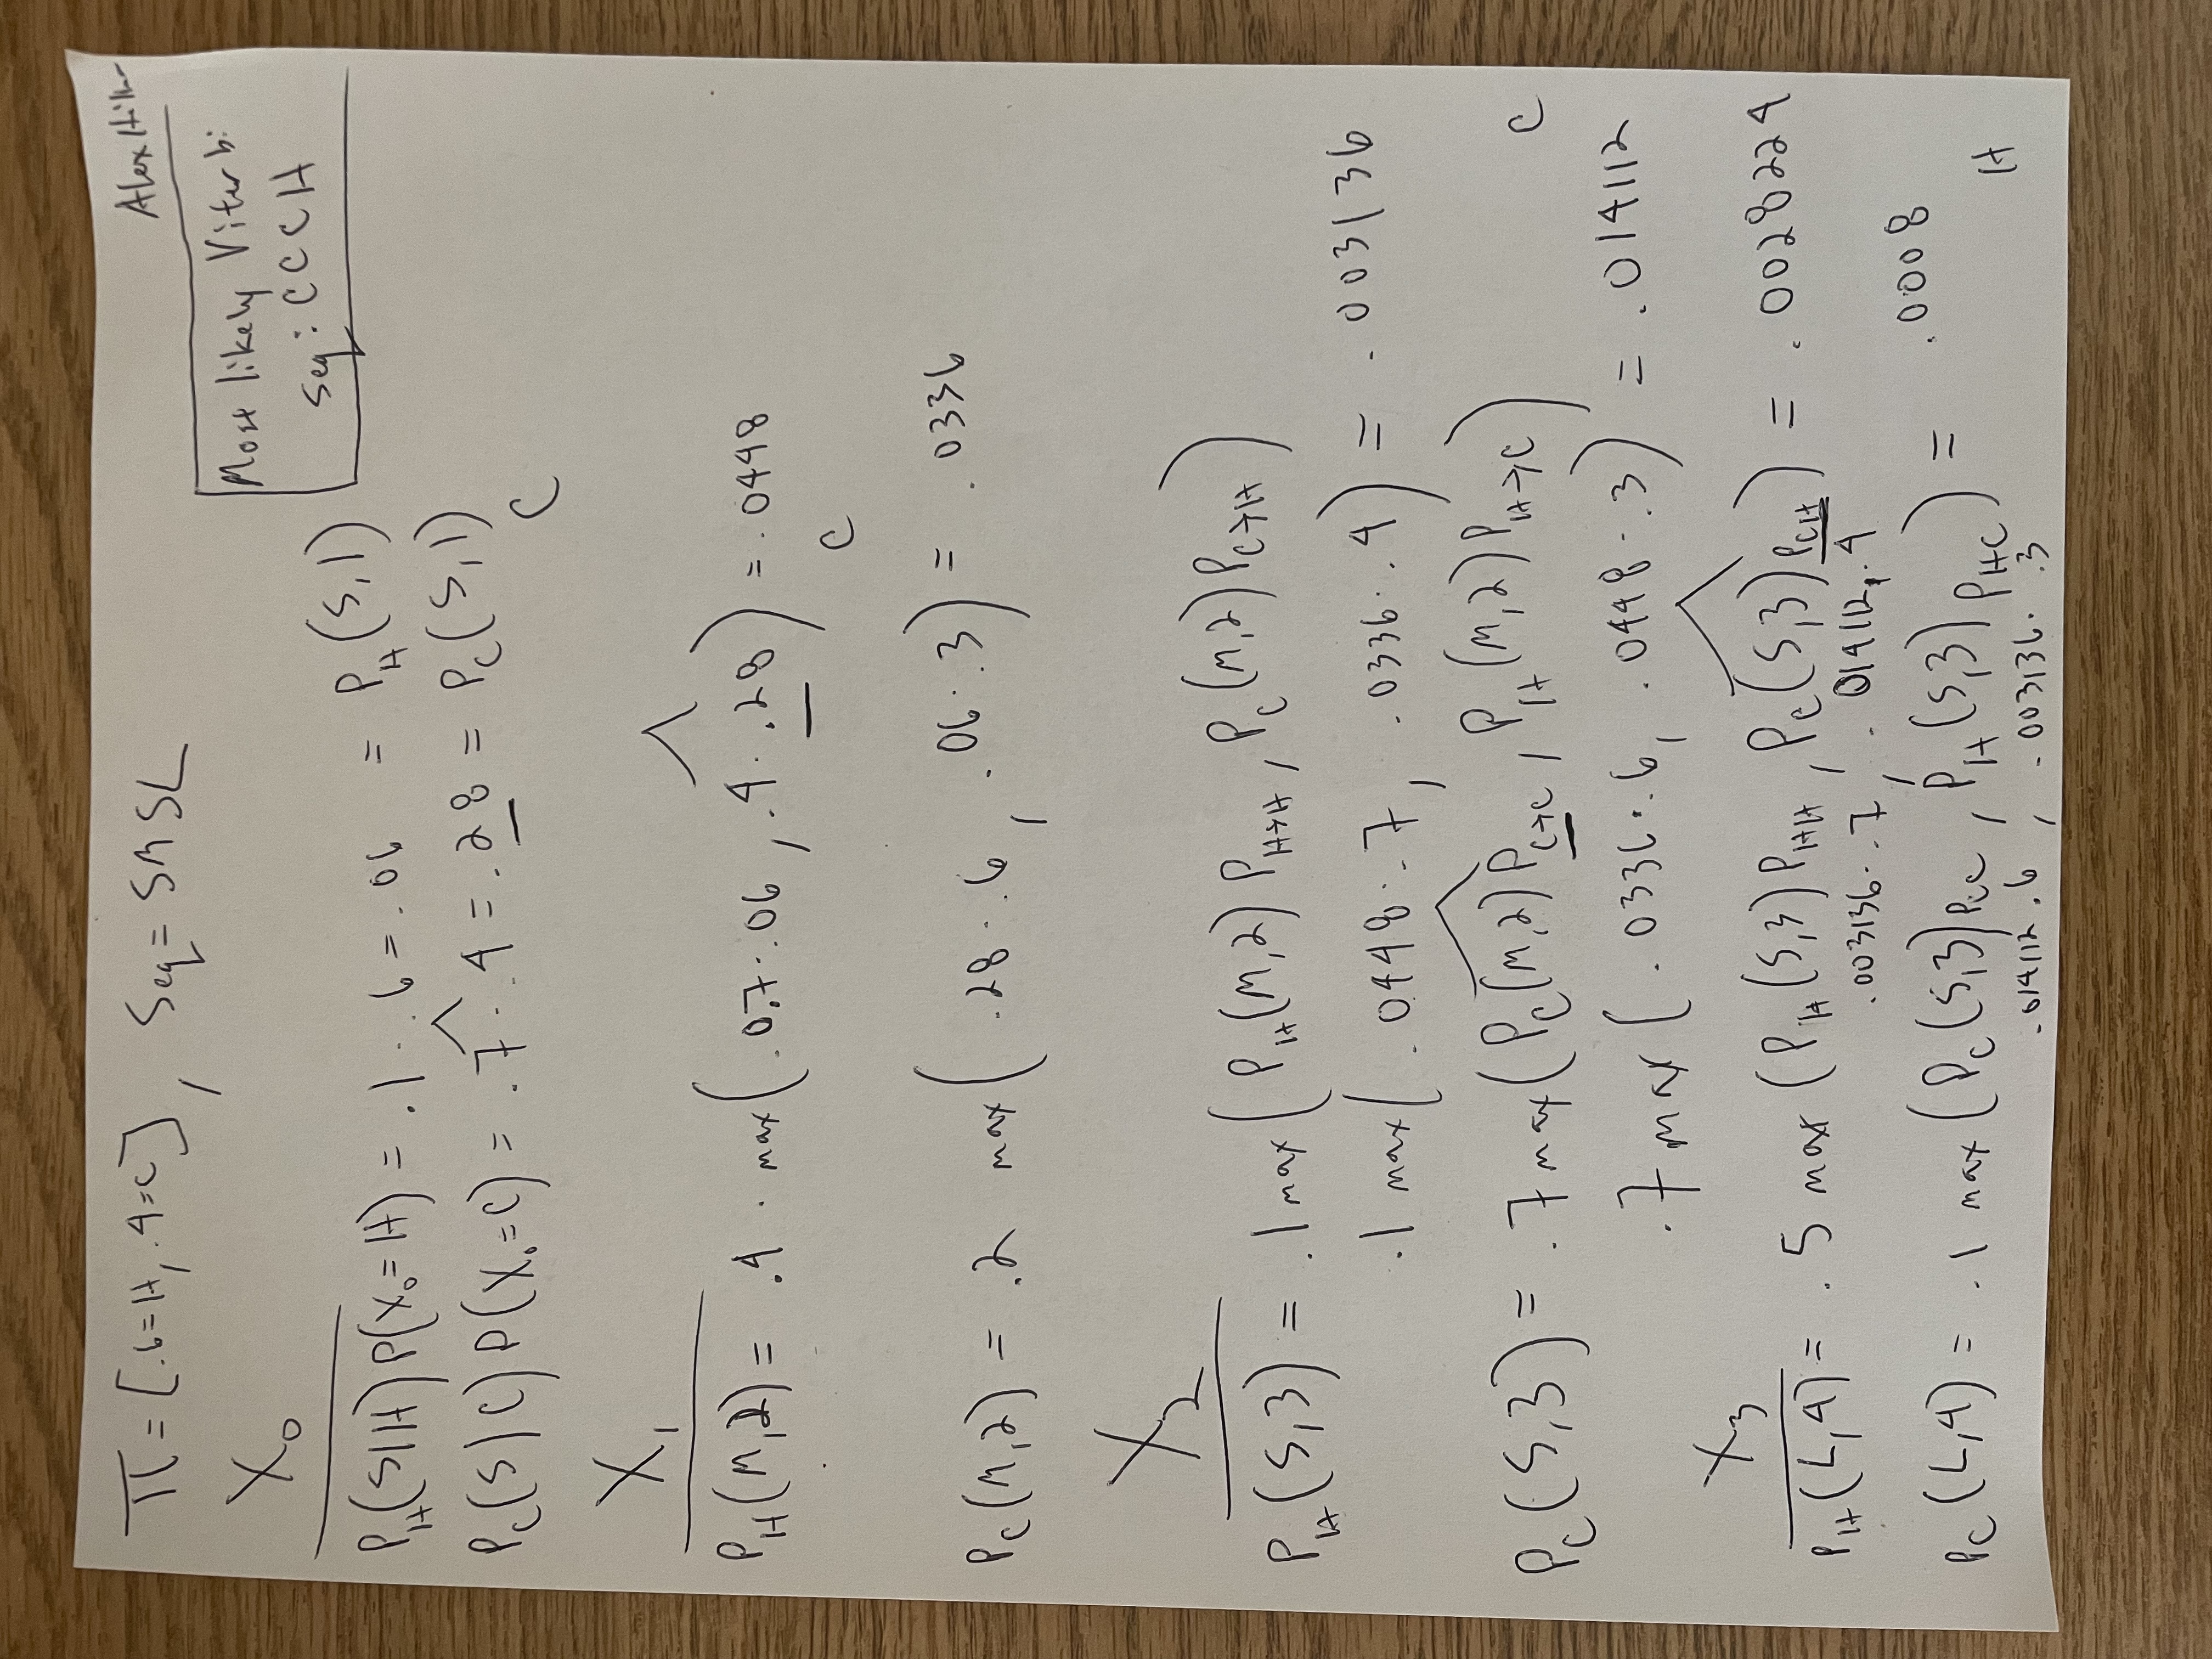

In [284]:
from IPython.core.display import Image, display
display(Image(filename='image.jpg'))